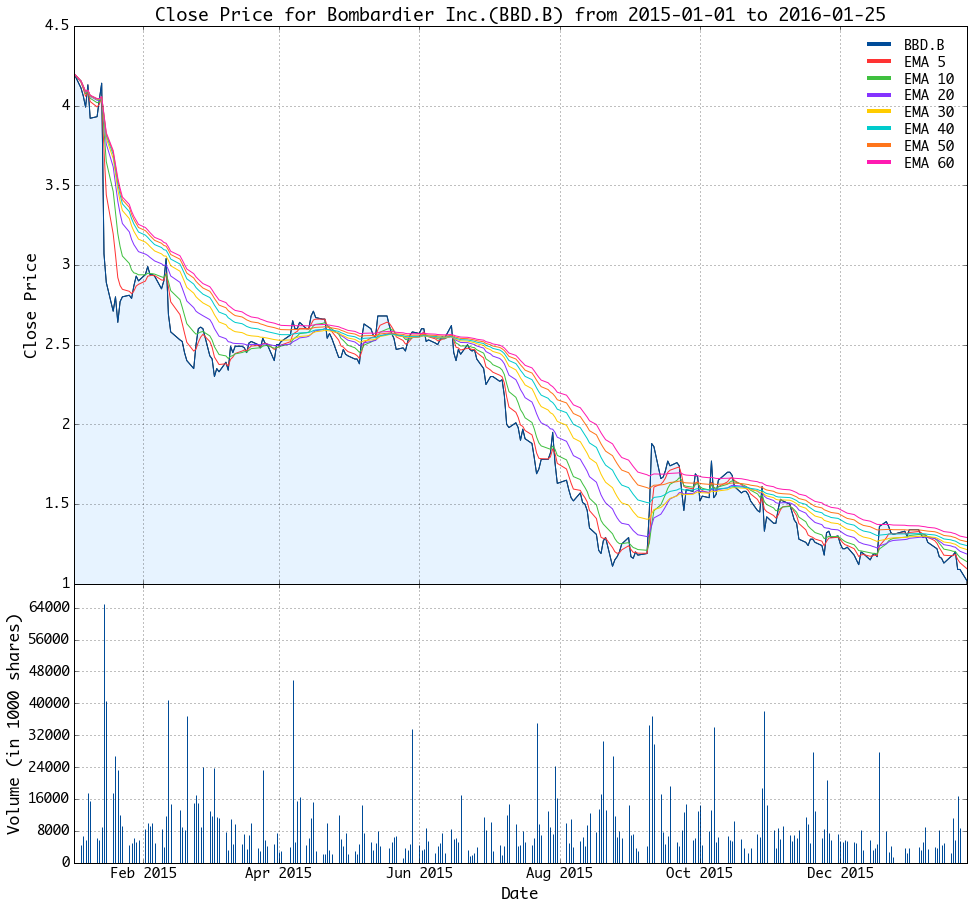

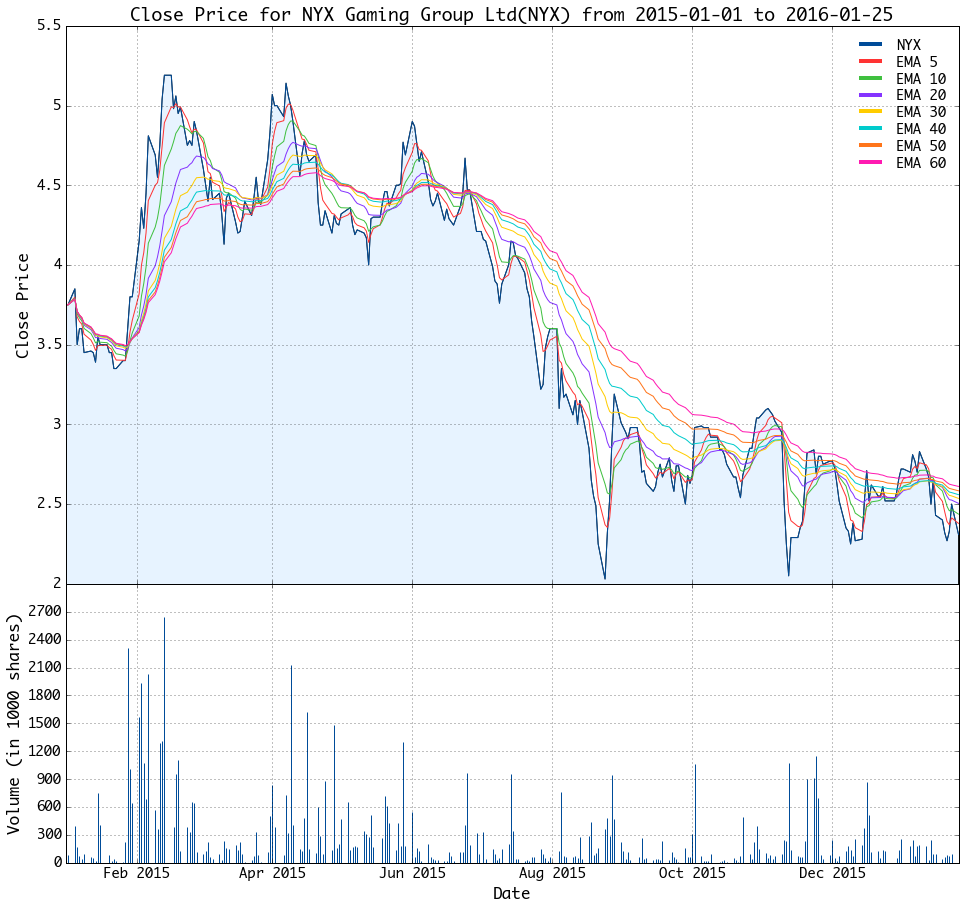

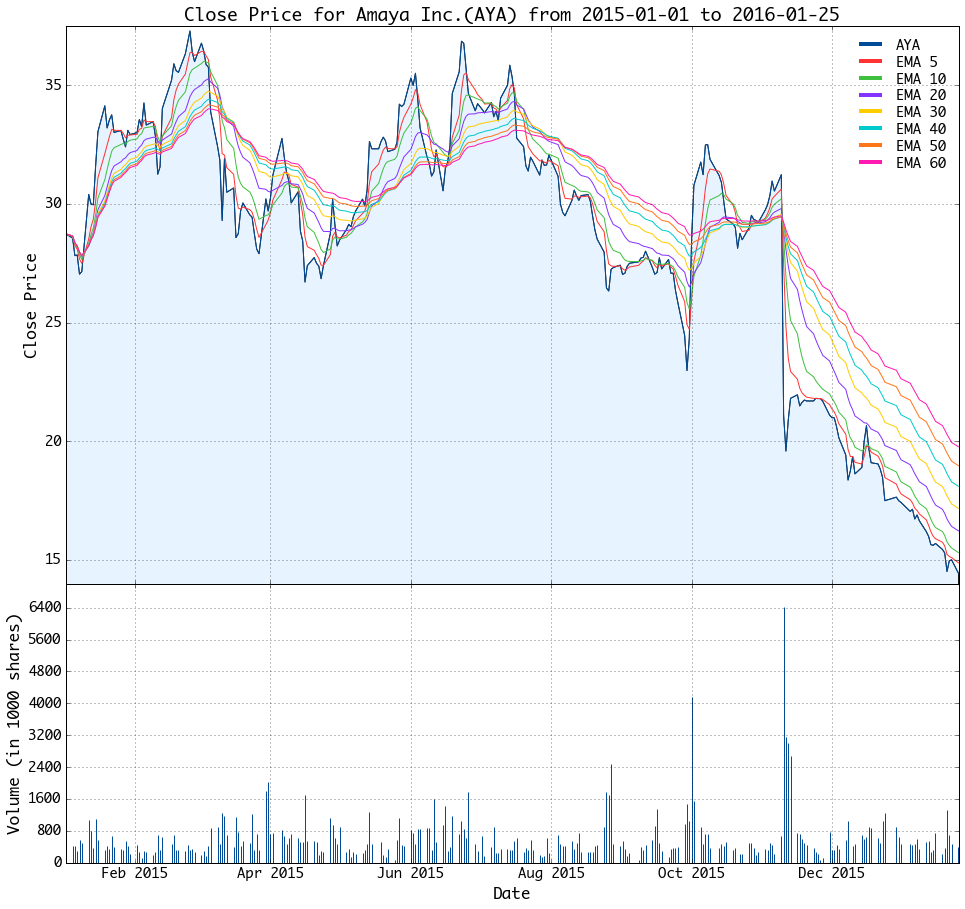

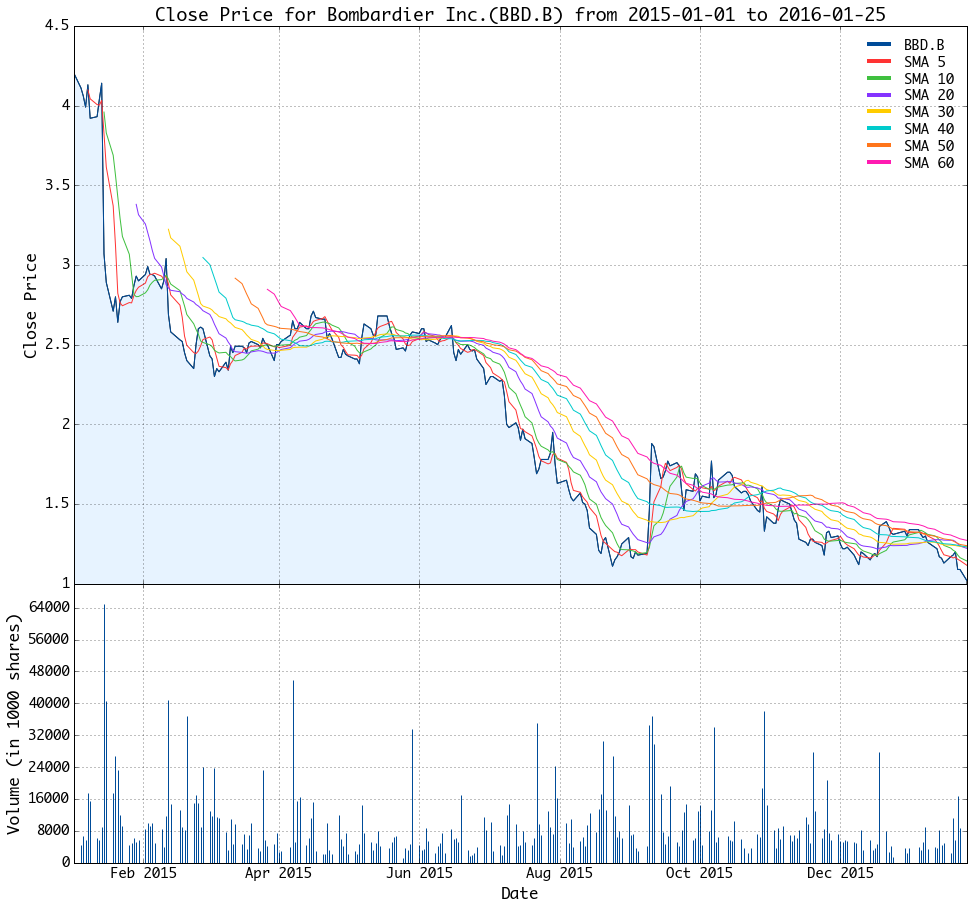

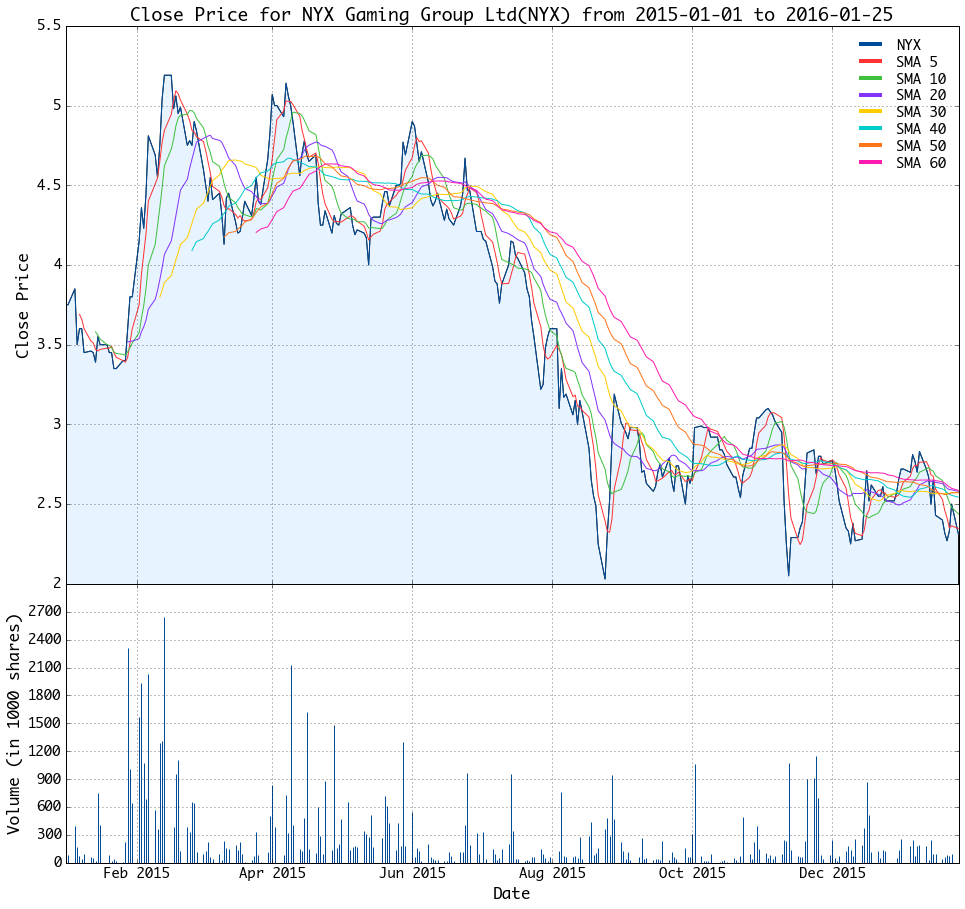

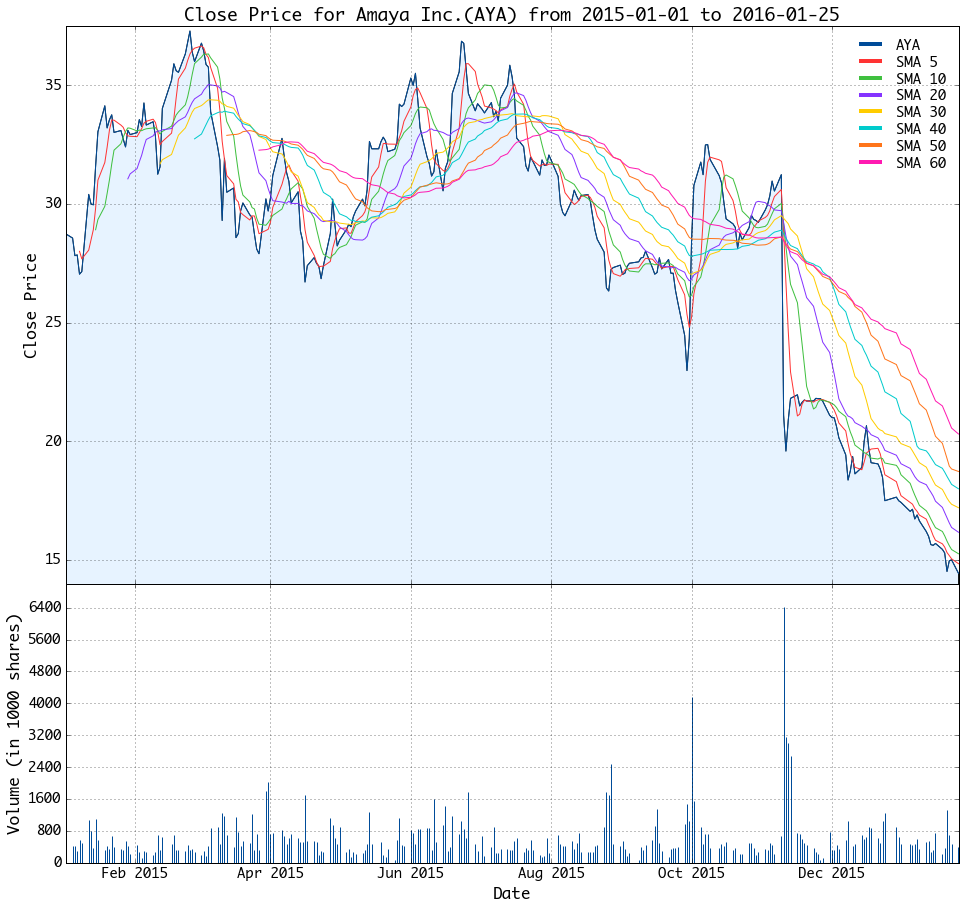

In [1]:
# import sys and os modules
import sys
import os
 
# add db to path
path = os.getcwd() + '/db'
if path not in sys.path:
    sys.path.append(path)
    
from db.data.utils import plot

# turn matplotlib inline
get_ipython().magic(u'matplotlib inline')

# plot tickers
tickers= ['BBD-B.TO','NYX.V', 'AYA.TO']
start_date = '2015-01-01'
end_date = '2016-01-25'

te = plot.PlotSymbol(tickers)
ma_type = 'exponential'
te.plot(ma_type=ma_type, start_date=start_date, end_date=end_date)
ma_type = 'simple'
te.plot(ma_type=ma_type, start_date=start_date, end_date=end_date)